In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
def _read_pickle(file_name):
    return pd.read_pickle(file_name)

def read_data(file_name):
    
    df = _read_pickle(file_name)
    a = [] 
    for t in df:
        a.append(np.squeeze(t.numpy(), 0))

    return a


# Data Loading

In [3]:
train = torch.load('jigsaw_toxic-comment_train_embedded_CLS_labse_bert.pkl')
#train = pd.read_csv('jigsaw_toxic-comment_train_embedded.pkl')
#train = pickle.load( open( 'jigsaw_toxic-comment_train_embedded.pkl', "rb" ) )

In [25]:
#val = torch.load('validation_es_only_text.pkl')
#val = pickle.load( open( 'validation_es_only_text.pkl', "rb" ) )
val = torch.load('validation_es_only_text_CLS_labse_bert.pkl')
val = [x.numpy() for x in val]

In [5]:
train_path = 'data/jigsaw-toxic-comment-train.csv'
val_path = 'data/val_es_toxic.csv' 

In [6]:
train_set = pd.read_csv(train_path)
val_set = pd.read_csv(val_path)

In [52]:
from sklearn.model_selection import train_test_split
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(train, train_set.toxic, test_size=0.33, random_state=42)

In [54]:
X_train_eng = np.squeeze(np.stack([x.numpy() for x in X_train_eng]))
X_test_eng = np.squeeze(np.stack([x.numpy() for x in X_test_eng]))
#val = np.squeeze(np.stack([x.numpy() for x in val]))

# Logistic regression

### Train - English only

In [77]:
%%time
pipe = make_pipeline(StandardScaler(), LogisticRegression( class_weight='balanced', max_iter=1000))
#pipe = make_pipeline(StandardScaler(), LogisticRegression( max_iter=1000))

pipe.fit(X_train_eng, y_train_eng)
#clf = LogisticRegression(random_state=0).fit(train[0:1000],list(val_set.toxic[0:1000]) )


CPU times: user 54.6 s, sys: 1.33 s, total: 55.9 s
Wall time: 16.2 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [78]:
import joblib

joblib.dump(pipe, "logistic_regression_LABSE.pkl") 

['logistic_regression_LABSE.pkl']

In [79]:
clf2 = joblib.load("logistic_regression_LABSE.pkl")

In [80]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(clf2.predict(X_train_eng), y_train_eng, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.89      0.99      0.94    122273
     class 1       0.90      0.47      0.62     27504

    accuracy                           0.89    149777
   macro avg       0.90      0.73      0.78    149777
weighted avg       0.89      0.89      0.88    149777



In [81]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(pipe.predict(X_train_eng), y_train_eng, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.89      0.99      0.94    122273
     class 1       0.90      0.47      0.62     27504

    accuracy                           0.89    149777
   macro avg       0.90      0.73      0.78    149777
weighted avg       0.89      0.89      0.88    149777



### Test- Spanish only

In [57]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(pipe.predict(val), list(val_set.toxic), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.76      0.95      0.85      1668
     class 1       0.81      0.41      0.55       832

    accuracy                           0.77      2500
   macro avg       0.79      0.68      0.70      2500
weighted avg       0.78      0.77      0.75      2500



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.870


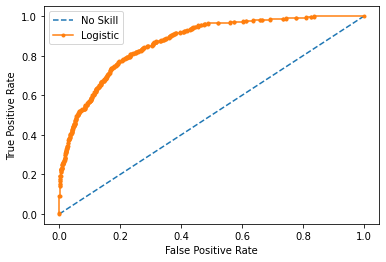

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(list(val_set.toxic)))]

lr_probs = pipe.predict_proba(val)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(list(val_set.toxic), ns_probs)
lr_auc = roc_auc_score(list(val_set.toxic), lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(list(val_set.toxic), ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(list(val_set.toxic), lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Test - English only

In [59]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(pipe.predict(X_test_eng), y_test_eng, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.89      0.99      0.94     60363
     class 1       0.88      0.46      0.61     13409

    accuracy                           0.89     73772
   macro avg       0.89      0.72      0.77     73772
weighted avg       0.89      0.89      0.88     73772



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.958


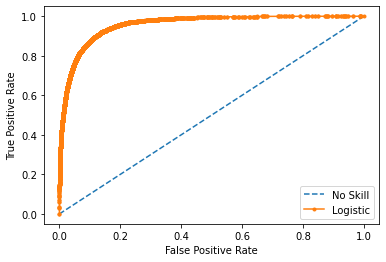

In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_eng))]

lr_probs = pipe.predict_proba(X_test_eng)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test_eng, ns_probs)
lr_auc = roc_auc_score(y_test_eng, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_eng, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_eng, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# MLP Classifier

### Train - English only

In [61]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=512, random_state=1, max_iter=300)

pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train_eng, y_train_eng)

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=512, max_iter=300,
                               random_state=1))])

In [62]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=512, random_state=1, max_iter=300)

pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train_eng[0:1000], y_train_eng[0:1000])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=512, max_iter=300,
                               random_state=1))])

In [63]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(pipe.predict(val), list(val_set.toxic), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.93      0.88      0.90      2179
     class 1       0.40      0.52      0.45       321

    accuracy                           0.84      2500
   macro avg       0.66      0.70      0.68      2500
weighted avg       0.86      0.84      0.85      2500



### Test- Spanish only

In [64]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(pipe.predict(val), list(val_set.toxic), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.93      0.88      0.90      2179
     class 1       0.40      0.52      0.45       321

    accuracy                           0.84      2500
   macro avg       0.66      0.70      0.68      2500
weighted avg       0.86      0.84      0.85      2500



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.819


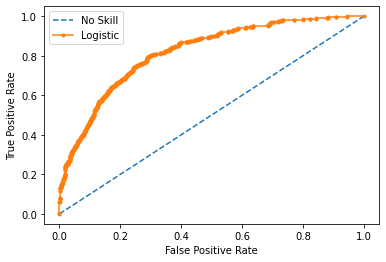

In [65]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(list(val_set.toxic)))]

lr_probs = pipe.predict_proba(val)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(list(val_set.toxic), ns_probs)
lr_auc = roc_auc_score(list(val_set.toxic), lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(list(val_set.toxic), ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(list(val_set.toxic), lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Test - English only


In [66]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(pipe.predict(X_test_eng), y_test_eng, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96     68393
     class 1       0.51      0.66      0.57      5379

    accuracy                           0.93     73772
   macro avg       0.74      0.81      0.77     73772
weighted avg       0.94      0.93      0.93     73772



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.912


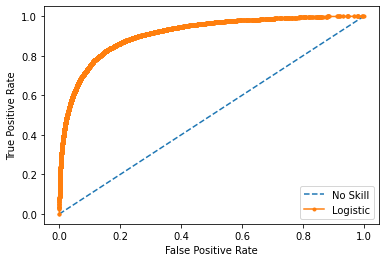

In [67]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_eng))]

lr_probs = pipe.predict_proba(X_test_eng)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test_eng, ns_probs)
lr_auc = roc_auc_score(y_test_eng, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_eng, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_eng, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Neural Network

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models

class net(nn.Module):

    def __init__(self):

        super(net, self).__init__()
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        # relu activation function
        self.relu =  nn.ReLU()
        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
    
    #define the forward pass
    def forward(self, in_vec):
        
        #pass the inputs to the model  
        x = self.fc1(in_vec)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc2(x)
        # apply softmax activation
        x = self.softmax(x)

        return x

In [69]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train_eng), y_train_eng)

print("Class Weights:",class_weights)



Class Weights: [0.55309084 5.20891006]


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=104964    0
217103    0
98660     0
86003     0
201197    0
         ..
119879    0
103694    0
131932    1
146867    0
121958    0
Name: toxic, Length: 149777, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [70]:
import time
import copy

train_loss = []
train_con = []

eval_loss = []
eval_con = []

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            i = 0 
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    #print(outputs, labels)

                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer


                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()
 

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #writer.add_histogram("conv1.weight_hist", model.conv1.weight, epoch)
            #writer.add_histogram("conv1.weight_avg", model.conv1.weight.mean(), epoch)
            #writer.add_histogram("model_loss", loss.item(), epoch)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_con.append(epoch_acc)
                i += 1
                #writer.add_scalar('training loss', running_loss / 1000, epoch * len(dataloaders['train']) + i) 
            if phase == 'val':
                eval_loss.append(epoch_loss)
                eval_con.append(epoch_acc)
                i += 1
                #writer.add_scalar('eval loss', running_loss / 1000, epoch * len(dataloaders['train']) + i) 
                #print("pred {0} lable: {1}".format(preds, labels.data))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'saved_weights.pt')
    return model, train_loss, train_con, eval_loss, eval_con

In [71]:
from transformers import AdamW

model = net()
model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

my_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [72]:
tensor_x_train = torch.from_numpy(np.array(X_train_eng)) # transform to torch tensor
tensor_y_train = torch.from_numpy(np.array(y_train_eng))

tensor_x_val = torch.from_numpy(np.array(X_test_eng)) # transform to torch tensor
tensor_y_val = torch.from_numpy(np.array(y_test_eng))

datasets = {'train':TensorDataset(tensor_x_train, tensor_y_train) ,'val':TensorDataset(tensor_x_val, tensor_y_val)  }


dataloaders_my = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=2)
  }

NameError: name 'TensorDataset' is not defined

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
#writer = SummaryWriter('/runs/')

# Train - English only

In [ ]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

train_loss = []
train_con = []

eval_loss = []
eval_con = []

num_epochs=10
#inputs, labels = inputs.to(device), labels.to(device)

model, train_loss, train_con, eval_loss, eval_con  = train_model(model, 
                    dataloaders_my,
                       cross_entropy, 
                       optimizer, 
                       my_lr_scheduler,
                       num_epochs=num_epochs)

In [ ]:
plt.figure(1)
plt.plot(train_loss, label='train')
plt.plot(eval_loss, label='eval')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()

plt.figure(2)
plt.plot(train_con, label='train')
plt.plot(eval_con, label='eval')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()
plt.show()

### Test - English only

In [ ]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad(): # No need to collect gradients when generating predictions
    for i, (inputs, labels) in enumerate(dataloaders_my['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        predlist=torch.cat([predlist, preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist, labels.view(-1).cpu()])

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(predlist, lbllist, target_names=target_names))

In [ ]:
# Initialize the prediction and label lists(tensors)
predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
problist = torch.zeros(0,dtype=torch.float, device='cpu')
inputslist = torch.zeros(0,dtype=torch.float, device='cpu')
outputslist = torch.zeros(0,dtype=torch.float, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_my['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        prob, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist = torch.cat([predlist, preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist, classes.view(-1).cpu()])
        problist = torch.cat([problist, torch.exp(prob).view(-1).cpu()])
        inputslist = torch.cat([inputslist, inputs.cpu()])
        outputslist = torch.cat([outputslist, outputs.cpu()])

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_eng))]

#lr_probs = pipe.predict_proba(X_test_eng)
# keep probabilities for the positive outcome only
lr_probs = problist
# calculate scores
ns_auc = roc_auc_score(y_test_eng, ns_probs)
lr_auc = roc_auc_score(y_test_eng, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_eng, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_eng, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Test- Spanish only

In [ ]:
tensor_x_val_spanish = torch.from_numpy(np.array(val)) # transform to torch tensor
tensor_y_val_spanish = torch.from_numpy(np.array(val_set.toxic))

datasets_spanish = {'val':TensorDataset(tensor_x_val_spanish, tensor_y_val_spanish)  }


dataloaders_spanish = {
    'val': torch.utils.data.DataLoader(datasets_spanish['val'], batch_size=16,
                                          shuffle=False, num_workers=2)
  }

In [ ]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad(): # No need to collect gradients when generating predictions
    for i, (inputs, labels) in enumerate(dataloaders_spanish['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        predlist=torch.cat([predlist, preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist, labels.view(-1).cpu()])

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']

print(classification_report(predlist, lbllist, target_names=target_names))

# Visualize the embeddings

In [ ]:
N=1000

In [ ]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23, n_jobs=7)
new_values = tsne_model.fit_transform(train[0:N])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
colors = ['red','blue']

fig = plt.figure(figsize=(8, 6))
plt.scatter(x[0:N], y[0:N], c=list(train_set.toxic)[0:N], cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)